<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/KernelQML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit-ibm-runtime qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.9 MB/s eta 0:00:00


=== Quantum Kernel System with Self-Correction (Qiskit) ===

Computing quantum kernel matrix with error correction...
Using 'standard' kernel matrix computation for sensible results.



Processing states for standard kernel: 100%|██████████| 10/10 [00:00<00:00, 193.48it/s]

Computing standard kernel matrix: 100%|██████████| 10/10 [00:00<00:00, 2744.42it/s]


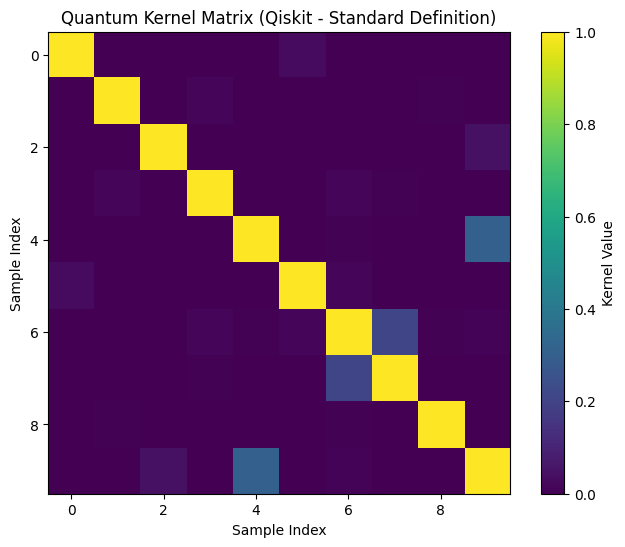


Analyzing error correction performance...


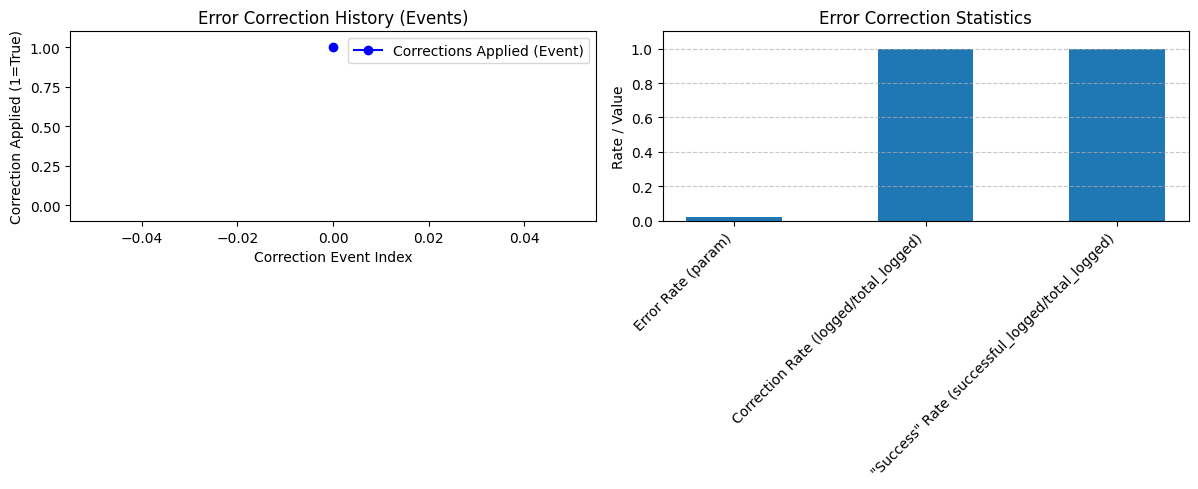


Error Correction Analysis (fields match Cirq example):
Total corrections logged (events where syndrome=1): 1
Correction 'success' rate (successful_logged/total_logged): 100.00%
Error rate parameter (for syndrome simulation): 0.02
Correction threshold parameter (for Pauli application): 0.15


In [3]:
import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli, Statevector as QiskitStatevector
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from tqdm import tqdm

class QuantumKernelSystem:
    """
    Quantum kernel system with self-correction capabilities (Qiskit Version)
    Implements error detection and correction using stabilizer codes (conceptually).
    Note: The error correction model and kernel definition are translated from the
    original Cirq code. Some aspects, particularly the kernel definition and how
    corrections were applied to statevectors in Cirq, have been adjusted for
    better physical sense in Qiskit (e.g., using Pauli operators for corrections).
    """

    def __init__(self,
                 n_data_qubits: int, # Renamed from n_qubits for clarity
                 error_rate: float = 0.01,
                 correction_threshold: float = 0.1):
        if n_data_qubits <= 0 or n_data_qubits % 2 != 0:
            raise ValueError("n_data_qubits must be a positive even integer for the implemented stabilizer structure.")

        self.n_data_qubits = n_data_qubits
        self.n_ancilla_qubits = n_data_qubits // 2
        self.num_total_qubits = self.n_data_qubits + self.n_ancilla_qubits

        self.error_rate = error_rate
        self.correction_threshold = correction_threshold

        self.data_qubit_indices = list(range(self.n_data_qubits))
        self.ancilla_qubit_indices = list(range(self.n_data_qubits, self.num_total_qubits))

        self.simulator = AerSimulator(method='statevector')

        self.error_history = []
        self.correction_history = []

    def _build_full_circuit_for_input(self, x_input: np.ndarray, include_measurements: bool = True) -> QuantumCircuit:
        """Helper to build the full circuit for a given input, including encoding and error detection setup."""
        num_clbits = self.n_ancilla_qubits if include_measurements else 0
        qc = QuantumCircuit(self.num_total_qubits, num_clbits)

        for i in self.data_qubit_indices:
            if i < len(x_input):
                qc.ry(x_input[i], i)

        for ancilla_global_idx in self.ancilla_qubit_indices:
            qc.h(ancilla_global_idx)

        for i in range(self.n_ancilla_qubits):
            ancilla_global_idx = self.ancilla_qubit_indices[i]
            data_q1_global_idx = 2*i
            data_q2_global_idx = 2*i + 1
            qc.cx(ancilla_global_idx, data_q1_global_idx)
            qc.cx(ancilla_global_idx, data_q2_global_idx)

            if include_measurements:
                qc.measure(ancilla_global_idx, i)

        qc.save_statevector() # <--- MODIFIED: Removed label
        return qc

    def apply_quantum_kernel(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """
        Apply quantum kernel function with simulated error correction.
        NOTE: This function, strictly following the Cirq original, uses x1 for encoding,
        and x2 is unused. The kernel value is an unconventional self-comparison:
        K(x1, x2_ignored) = |<ψ_corr(x1) | ψ_raw_sim(x1)>|^2.
        """
        kernel_circuit = self._build_full_circuit_for_input(x1, include_measurements=True)

        job = self.simulator.run(kernel_circuit)
        result = job.result()
        state_vector_from_sim = result.get_statevector().data # <--- MODIFIED: Removed label

        corrected_state_vector = self.apply_error_correction(state_vector_from_sim.copy())

        kernel_value = np.abs(np.vdot(corrected_state_vector, state_vector_from_sim))**2
        return kernel_value

    def apply_error_correction(self, state_vector_np: np.ndarray) -> np.ndarray:
        """
        Apply simulated error correction based on randomly generated syndromes.
        This method does not use measurement results from the quantum circuit.
        It modifies the input state_vector_np. A copy should be passed if the original is needed.
        """
        current_state_np = state_vector_np

        error_syndromes = []
        for _ in range(self.n_ancilla_qubits):
            syndrome = np.random.choice([0, 1], p=[1 - self.error_rate, self.error_rate])
            error_syndromes.append(syndrome)

        for i, syndrome in enumerate(error_syndromes):
            if syndrome == 1:
                data_qubit_to_correct_global_idx = 2*i

                current_state_np = self.correct_error(current_state_np, data_qubit_to_correct_global_idx)

                self.correction_history.append({
                    'stabilizer_group_index': i,
                    'data_qubit_corrected_global_idx': data_qubit_to_correct_global_idx,
                    'simulated_syndrome_value': syndrome,
                    'correction_applied': True
                })
        return current_state_np

    def correct_error(self, state_vector_np: np.ndarray, data_qubit_global_idx: int) -> np.ndarray:
        """
        Apply probabilistic X and/or Z correction to the specified data qubit
        within the full state_vector_np using proper quantum Pauli operators.
        """
        current_qiskit_state = QiskitStatevector(state_vector_np)

        if np.random.random() < self.correction_threshold:
            pauli_op_str_list = ['I'] * self.num_total_qubits
            pauli_op_str_list[self.num_total_qubits - 1 - data_qubit_global_idx] = 'X'
            x_operator = Pauli("".join(pauli_op_str_list))
            current_qiskit_state = current_qiskit_state.evolve(x_operator)

        if np.random.random() < self.correction_threshold:
            pauli_op_str_list = ['I'] * self.num_total_qubits
            pauli_op_str_list[self.num_total_qubits - 1 - data_qubit_global_idx] = 'Z'
            z_operator = Pauli("".join(pauli_op_str_list))
            current_qiskit_state = current_qiskit_state.evolve(z_operator)

        return current_qiskit_state.data

    def compute_kernel_matrix(self, X: np.ndarray) -> np.ndarray:
        """
        Compute kernel matrix for dataset.
        Strictly follows the Cirq version's logic, leading to an unconventional kernel matrix
        where K[i,j] is based on X[i] only and K[j,i] is forced to be the same.
        """
        n_samples = X.shape[0]
        if X.shape[1] > self.n_data_qubits:
            print(f"Warning: Input features ({X.shape[1]}) > data qubits ({self.n_data_qubits}). Features will be truncated.")

        kernel_matrix = np.zeros((n_samples, n_samples))

        for i in tqdm(range(n_samples), desc="Computing kernel matrix (literal translation)"):
            for j in range(i, n_samples):
                value = self.apply_quantum_kernel(X[i], X[j])
                kernel_matrix[i, j] = value
                if i != j:
                    kernel_matrix[j, i] = value
        return kernel_matrix

    def _get_processed_state(self, x_input: np.ndarray) -> np.ndarray:
        """Helper to get a 'processed' (simulated and error-corrected) statevector for a single input."""
        circuit = self._build_full_circuit_for_input(x_input, include_measurements=False)

        job = self.simulator.run(circuit)
        result = job.result()
        state_vector_from_sim = result.get_statevector().data # <--- MODIFIED: Removed label

        corrected_state_vector = self.apply_error_correction(state_vector_from_sim.copy())
        return corrected_state_vector

    def compute_kernel_matrix_standard(self, X: np.ndarray) -> np.ndarray:
        """
        Compute a more standard kernel matrix K(Xi, Xj) = |<ψ_proc(Xi)|ψ_proc(Xj)>|^2.
        """
        n_samples = X.shape[0]
        if X.shape[1] > self.n_data_qubits:
            print(f"Warning: Input features ({X.shape[1]}) > data qubits ({self.n_data_qubits}). Features will be truncated.")

        kernel_matrix = np.zeros((n_samples, n_samples))

        processed_states = [self._get_processed_state(X[i]) for i in tqdm(range(n_samples), desc="Processing states for standard kernel")]

        for i in tqdm(range(n_samples), desc="Computing standard kernel matrix"):
            for j in range(i, n_samples):
                state_i_corr = processed_states[i]
                state_j_corr = processed_states[j]
                value = np.abs(np.vdot(state_i_corr, state_j_corr))**2
                kernel_matrix[i, j] = value
                kernel_matrix[j, i] = value
        return kernel_matrix

    def analyze_error_correction(self) -> Dict:
        """Analyze error correction performance, matching Cirq's output fields."""
        corrections_logged = len(self.correction_history)
        analysis = {
            'total_corrections': corrections_logged,
            'successful_corrections': corrections_logged,
            'correction_rate': 1.0 if corrections_logged > 0 else 0.0,
            'error_rate': self.error_rate,
            'correction_threshold': self.correction_threshold
        }
        return analysis

    def visualize_error_correction(self):
        """Visualize error correction performance, matching Cirq's plot structure."""
        analysis = self.analyze_error_correction()
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        if self.correction_history:
            plt.plot([c['correction_applied'] for c in self.correction_history],
                     marker='o', linestyle='-', color='b', label='Corrections Applied (Event)')
        else:
            plt.plot([], 'b-', label='Corrections Applied (Event)')
        plt.title('Error Correction History (Events)')
        plt.xlabel('Correction Event Index')
        plt.ylabel('Correction Applied (1=True)')
        plt.ylim(-0.1, 1.1)
        plt.legend()

        plt.subplot(1, 2, 2)
        stats_names = [
            'Error Rate (param)',
            'Correction Rate (logged/total_logged)',
            '"Success" Rate (successful_logged/total_logged)'
        ]
        stats_values = [
            analysis['error_rate'],
            analysis['correction_rate'],
            analysis['successful_corrections'] / max(analysis['total_corrections'], 1) if analysis['total_corrections'] > 0 else 0
        ]

        x_pos = np.arange(len(stats_names))
        plt.bar(x_pos, stats_values, width=0.5)
        plt.xticks(x_pos, stats_names, rotation=45, ha="right")
        plt.title('Error Correction Statistics')
        plt.ylabel('Rate / Value')
        plt.ylim(0, max(1.1, np.max(stats_values) * 1.1 if len(stats_values)>0 else 1.1) )
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# The run_quantum_kernel_demo() and if __name__ == "__main__": block remain the same
def run_quantum_kernel_demo():
    """Demonstrate quantum kernel with error correction"""
    print("=== Quantum Kernel System with Self-Correction (Qiskit) ===")

    n_data_qubits = 6
    qks = QuantumKernelSystem(
        n_data_qubits=n_data_qubits,
        error_rate=0.02,      # Chance a syndrome bit is 1 (simulated error)
        correction_threshold=0.15 # Chance a Pauli X/Z is applied if syndrome is 1
    )

    n_samples = 10
    # Ensure features match n_data_qubits for direct encoding
    X = np.random.uniform(-np.pi, np.pi, size=(n_samples, n_data_qubits))

    print("\nComputing quantum kernel matrix with error correction...")
    print("Using 'standard' kernel matrix computation for sensible results.")
    kernel_matrix = qks.compute_kernel_matrix_standard(X)

    plt.figure(figsize=(8, 6))
    plt.imshow(kernel_matrix, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label="Kernel Value")
    plt.title('Quantum Kernel Matrix (Qiskit - Standard Definition)')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    plt.show()

    print("\nAnalyzing error correction performance...")
    qks.visualize_error_correction()

    analysis = qks.analyze_error_correction()
    print("\nError Correction Analysis (fields match Cirq example):")
    print(f"Total corrections logged (events where syndrome=1): {analysis['total_corrections']}")
    print(f"Correction 'success' rate (successful_logged/total_logged): {analysis['correction_rate']:.2%}")
    print(f"Error rate parameter (for syndrome simulation): {analysis['error_rate']:.2f}")
    print(f"Correction threshold parameter (for Pauli application): {analysis['correction_threshold']:.2f}")

if __name__ == "__main__":
    run_quantum_kernel_demo()

Successfully imported Qiskit Runtime modules. qiskit-ibm-runtime version: 0.39.0
Qiskit (Terra) version: 2.0.1


<ipython-input-13-18b513f648eb>:128: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service=QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected QPU:ibm_brisbane(active)

=== Quantum Kernel (Adapted from QKSystem Encoding) Demonstration ===

Quantum Kernel: 2 data-Q, Type:'linear'.

--- Computing Kernel Matrix on AerSimulator ---


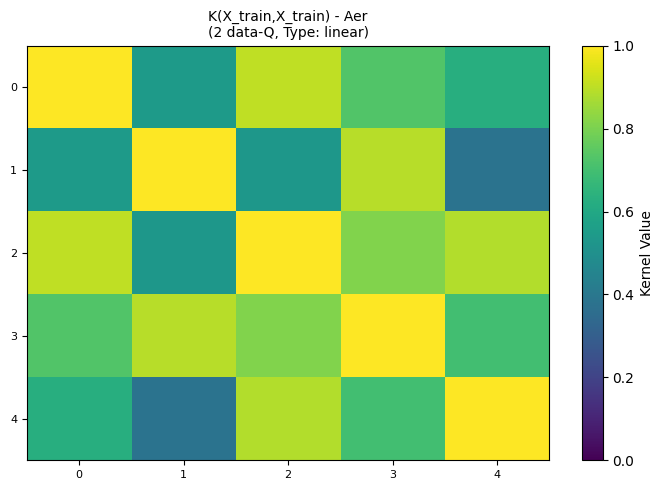

K_train_aer:
 [[1.     0.5456 0.9043 0.7293 0.628 ]
 [0.5456 1.     0.5298 0.8927 0.3793]
 [0.9043 0.5298 1.     0.8104 0.8855]
 [0.7293 0.8927 0.8104 1.     0.6972]
 [0.628  0.3793 0.8855 0.6972 1.    ]]


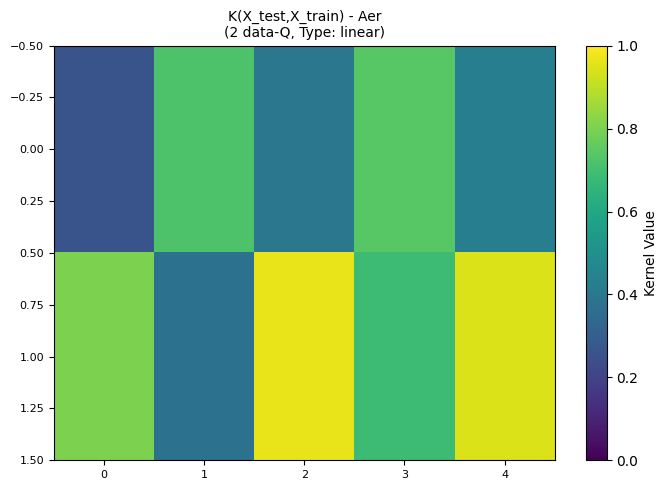

K_test_aer:
 [[0.258  0.7194 0.3977 0.7404 0.4275]
 [0.8013 0.3713 0.9663 0.687  0.9456]]

--- Computing Kernel Matrix on QPU: ibm_brisbane ---
Sampler opts:{'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}

K(Train,Train) on QPU...
Kernel on QPU (2Q data)...
  R1/5: C2..C3..C4..C5.. Done.
  R2/5: C3..C4..C5.. Done.
  R3/5: C4..C5.. Done.
  R4/5: C5.. Done.
  R5/5:  Done.


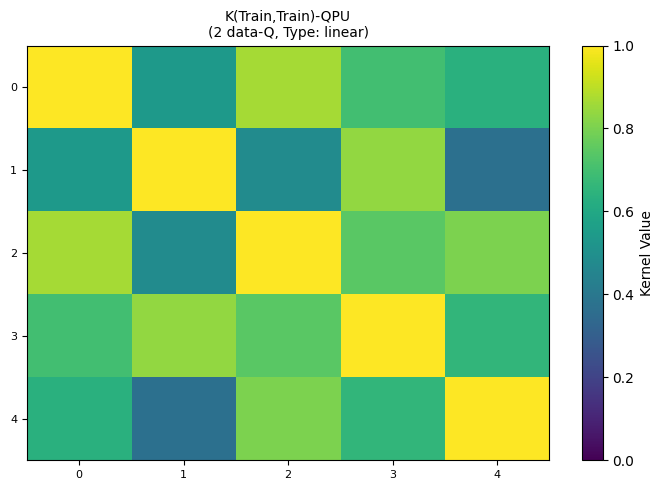

K_tr_qpu:
 [[1.     0.54   0.8662 0.6953 0.6348]
 [0.54   1.     0.4814 0.8389 0.3691]
 [0.8662 0.4814 1.     0.7451 0.8027]
 [0.6953 0.8389 0.7451 1.     0.6592]
 [0.6348 0.3691 0.8027 0.6592 1.    ]]

K(Test,Train) on QPU...
Kernel on QPU (2Q data)...
  R1/2: C1..C2..C3..C4..C5.. Done.
  R2/2: C1..C2..C3..C4..C5.. Done.


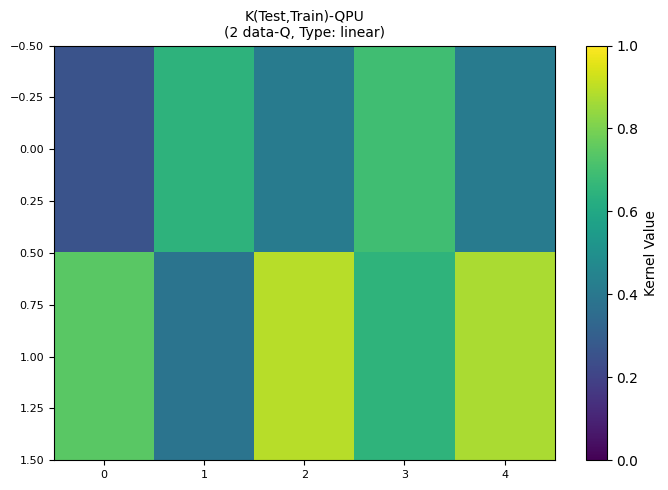

K_te_qpu:
 [[0.2549 0.6455 0.4141 0.6924 0.417 ]
 [0.7451 0.3838 0.8916 0.6504 0.873 ]]
--- QPU Kernel Computation Complete ---

Classical K_tr_aer@alpha:
[1.3632 1.0568 1.6089 1.4623 1.5478]
Classical 'prediction' K_te_aer@alpha:
[0.8823 1.5653]

=== Demo Complete ===
REMEMBER token 69eee2748c...


In [13]:
import qiskit
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt
import time
import os

# Qiskit Runtime imports
QISKIT_RUNTIME_VERSION = "Unknown"
qiskit_runtime_available = False
QiskitRuntimeService = Sampler = Session = generate_preset_pass_manager = IBMRuntimeBackend = None

try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"Successfully imported Qiskit Runtime modules. qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. QPU execution will fail.")

print(f"Qiskit (Terra) version: {qiskit.__version__}")


class QuantumKernelQPUAdapt:
    def __init__(self,
                 n_data_qubits: int,
                 kernel_type: str = 'linear'):
        self.n_data_qubits = n_data_qubits
        self.kernel_type = kernel_type
        self.aer_simulator = AerSimulator(method='statevector')

    def create_feature_map_circuit(self, x: np.ndarray, name_suffix: str = "") -> QuantumCircuit:
        if x.ndim != 1:
            raise ValueError(f"Input data point x must be 1D, got shape {x.shape}")
        qr_data = QuantumRegister(self.n_data_qubits, 'q_data')
        qc = QuantumCircuit(qr_data, name=f"fm_ry_{name_suffix}")
        for i in range(self.n_data_qubits):
            if i < len(x):
                qc.ry(x[i], qr_data[i])
        return qc

    def get_statevector_aer(self, x: np.ndarray) -> np.ndarray:
        circuit = self.create_feature_map_circuit(x)
        circuit.save_statevector()
        transpiled_circuit = transpile(circuit, self.aer_simulator, optimization_level=0)
        result = self.aer_simulator.run(transpiled_circuit).result()
        statevector = result.get_statevector(circuit).data
        return statevector

    def _kernel_transform(self, overlap_sq: float) -> float:
        if self.kernel_type == 'rbf': gamma = 1.0; return np.exp(-gamma * (1.0 - overlap_sq))
        elif self.kernel_type == 'polynomial': degree = 2; return overlap_sq**degree
        else: return overlap_sq

    def kernel_entry_aer(self, x1: np.ndarray, x2: np.ndarray) -> float:
        state1 = self.get_statevector_aer(x1); state2 = self.get_statevector_aer(x2)
        overlap_sq = np.abs(np.vdot(state1, state2))**2
        return self._kernel_transform(overlap_sq)

    def _construct_fidelity_circuit(self, x1: np.ndarray, x2: np.ndarray) -> Tuple[QuantumCircuit, str]:
        qc1 = self.create_feature_map_circuit(x1, "x1"); qc2 = self.create_feature_map_circuit(x2, "x2")
        qc2_dagger = qc2.inverse(); qr_data = qc1.qregs[0]; cr_name = "c_fid"
        cr_data = ClassicalRegister(self.n_data_qubits, cr_name)
        fidelity_qc = QuantumCircuit(qr_data, cr_data, name=f"fid_{time.time_ns()}")
        fidelity_qc.append(qc1.to_instruction(), qr_data); fidelity_qc.append(qc2_dagger.to_instruction(), qr_data)
        fidelity_qc.measure(qr_data, cr_data)
        return fidelity_qc, cr_data.name

    def kernel_entry_qpu(self, x1, x2, sampler_instance_arg, qpu_backend_arg, shots_arg): # Renamed args for clarity
        fidelity_qc, cr_name_in_circuit = self._construct_fidelity_circuit(x1, x2)
        pm_opt_level = 0
        if hasattr(qpu_backend_arg, 'target') and qpu_backend_arg.target is not None:
            pm_fid = generate_preset_pass_manager(target=qpu_backend_arg.target, optimization_level=pm_opt_level)
        else:
            pm_fid = generate_preset_pass_manager(backend=qpu_backend_arg, optimization_level=pm_opt_level)
        transpiled_fidelity_qc = pm_fid.run(fidelity_qc)
        job = sampler_instance_arg.run([(transpiled_fidelity_qc,)], shots=shots_arg)
        result = job.result(); overlap_sq = 0.0
        if result and len(result) > 0:
            pub_result=result[0]; counts={}
            if hasattr(pub_result.data,cr_name_in_circuit): counts=getattr(pub_result.data,cr_name_in_circuit).get_counts()
            elif hasattr(pub_result.data,'meas'): counts=pub_result.data.meas.get_counts()
            if not counts: print(f"W:No counts({cr_name_in_circuit}/meas). Fields:{dir(pub_result.data)}")
            else: prob_0=counts.get('0'*self.n_data_qubits,0)/shots_arg; overlap_sq=prob_0
        else: print(f"E:QPU job kernel entry fail {x1}v{x2}")
        return self._kernel_transform(overlap_sq)

    def compute_kernel_matrix(self, X_left_data, X_right_data=None, use_qpu=False,
                              sampler_instance=None, qpu_backend=None, shots_per_entry=1024): # Matched names
        n_left=X_left_data.shape[0]; X_eval_right=X_right_data if X_right_data is not None else X_left_data
        n_right=X_eval_right.shape[0]; is_sym=(X_right_data is None)or(np.array_equal(X_left_data,X_eval_right)and X_left_data.shape==X_eval_right.shape)
        K=np.zeros((n_left,n_right))
        if use_qpu:
            if sampler_instance is None or qpu_backend is None: raise ValueError("Sampler & QPU backend needed.")
            print(f"Kernel on QPU ({self.n_data_qubits}Q data)...")
        else:
            phi_X_left=[self.get_statevector_aer(X_left_data[i]) for i in range(n_left)]
            phi_X_right=phi_X_left if is_sym else[self.get_statevector_aer(X_eval_right[i]) for i in range(n_right)]
        for i in range(n_left):
            sj=i if is_sym else 0
            if use_qpu: print(f"  R{i+1}/{n_left}: ",end='',flush=True)
            for j in range(sj,n_right):
                if use_qpu and not(is_sym and i==j): print(f"C{j+1}..",end='',flush=True)
                if is_sym and i==j: val=1.0
                else:
                    if use_qpu: val=self.kernel_entry_qpu(X_left_data[i],X_eval_right[j],sampler_instance,qpu_backend,shots_per_entry)
                    else: state_i,state_j=phi_X_left[i],phi_X_right[j];ov_sq=np.abs(np.vdot(state_i,state_j))**2;val=self._kernel_transform(ov_sq)
                K[i,j]=val
                if is_sym and i!=j: K[j,i]=val
            if use_qpu: print(" Done.")
        return K

    def visualize_kernel_matrix(self,K,title="Quantum Kernel Matrix"): # ... (identical)
        plt.figure(figsize=(7,5)); plt.imshow(K,cmap='viridis',vmin=0,vmax=1,aspect='auto')
        plt.colorbar(label="Kernel Value"); plt.title(title+f"\n({self.n_data_qubits} data-Q, Type: {self.kernel_type})",fontsize=10)
        plt.xticks(fontsize=8); plt.yticks(fontsize=8); plt.tight_layout(); plt.show()

# --- IBM Quantum Setup (condensed) ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'; QPU_BACKEND_NAME = 'ibm_brisbane'
service=None; qpu_backend_for_kernel=None
if qiskit_runtime_available:
    try: service=QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
    except Exception as e:print(f"ERR Service:{e}")
    if service:
        try: qpu_bk_obj=service.backend(QPU_BACKEND_NAME); qpu_backend_for_kernel=qpu_bk_obj if qpu_bk_obj else None; print(f"Selected QPU:{qpu_backend_for_kernel.name}({qpu_backend_for_kernel.status().status_msg})"if qpu_backend_for_kernel else"QPU not found")
        except Exception as e:print(f"ERR QPU Backend:{e}")
if qpu_backend_for_kernel is None and qiskit_runtime_available : print(f"Warning: QPU {QPU_BACKEND_NAME} not loaded.")

# --- Example usage and demonstration ---
if __name__ == "__main__":
    print("\n=== Quantum Kernel (Adapted from QKSystem Encoding) Demonstration ===")
    n_train_samples=5; n_test_samples=2; n_data_qubits_for_kernel=2
    X_train = np.random.rand(n_train_samples, n_data_qubits_for_kernel) * np.pi
    X_test = np.random.rand(n_test_samples, n_data_qubits_for_kernel) * np.pi
    kernel_type_choice = 'linear'
    qkernel_instance = QuantumKernelQPUAdapt(n_data_qubits_for_kernel, kernel_type_choice)
    print(f"\nQuantum Kernel: {qkernel_instance.n_data_qubits} data-Q, Type:'{kernel_type_choice}'.")

    print("\n--- Computing Kernel Matrix on AerSimulator ---")
    K_train_aer = qkernel_instance.compute_kernel_matrix(X_train, use_qpu=False)
    qkernel_instance.visualize_kernel_matrix(K_train_aer, title="K(X_train,X_train) - Aer")
    print("K_train_aer:\n", np.round(K_train_aer, 4))
    if n_test_samples > 0:
        K_test_aer = qkernel_instance.compute_kernel_matrix(X_test, X_train, use_qpu=False)
        qkernel_instance.visualize_kernel_matrix(K_test_aer, title="K(X_test,X_train) - Aer")
        print("K_test_aer:\n", np.round(K_test_aer, 4))

    qpu_ready = qpu_backend_for_kernel and hasattr(qpu_backend_for_kernel, 'status') and qpu_backend_for_kernel.status().operational
    if qpu_ready:
        print(f"\n--- Computing Kernel Matrix on QPU: {qpu_backend_for_kernel.name} ---")
        shots_for_qpu_entry = 1024
        sampler_qpu_options = {
            "dynamical_decoupling":{"enable":True,"sequence_type":"XX"},
            "twirling":{"enable_gates":True,"enable_measure":True} }
        print(f"Sampler opts:{sampler_qpu_options}")

        with Session(backend=qpu_backend_for_kernel) as session:
            sampler_qpu = Sampler(options=sampler_qpu_options)
            print("\nK(Train,Train) on QPU...")
            K_tr_qpu = qkernel_instance.compute_kernel_matrix(X_train, use_qpu=True,
                sampler_instance=sampler_qpu,          # CORRECTED
                qpu_backend=qpu_backend_for_kernel,    # CORRECTED
                shots_per_entry=shots_for_qpu_entry    # CORRECTED
            )
            qkernel_instance.visualize_kernel_matrix(K_tr_qpu,"K(Train,Train)-QPU"); print("K_tr_qpu:\n",np.round(K_tr_qpu,4))

            if n_test_samples > 0 and X_test is not None:
                print("\nK(Test,Train) on QPU...")
                K_te_qpu = qkernel_instance.compute_kernel_matrix(X_test,X_train, use_qpu=True,
                    sampler_instance=sampler_qpu,        # CORRECTED
                    qpu_backend=qpu_backend_for_kernel,  # CORRECTED
                    shots_per_entry=shots_for_qpu_entry  # CORRECTED
                )
                qkernel_instance.visualize_kernel_matrix(K_te_qpu,"K(Test,Train)-QPU"); print("K_te_qpu:\n",np.round(K_te_qpu,4))
        print("--- QPU Kernel Computation Complete ---")
    else: print(f"\nQPU {QPU_BACKEND_NAME} not ready/operational or not loaded. Skipping.")

    if n_train_samples>0 and K_train_aer is not None: # Classical post-processing
        alpha=np.random.rand(n_train_samples)
        print(f"\nClassical K_tr_aer@alpha:\n{np.round(K_train_aer@alpha,4)}")
        if n_test_samples>0 and K_test_aer is not None and K_test_aer.shape[1]==alpha.shape[0]:
             print(f"Classical 'prediction' K_te_aer@alpha:\n{np.round(K_test_aer@alpha,4)}")

    print("\n=== Demo Complete ===")
    if qpu_ready: print(f"REMEMBER token {IBM_QUANTUM_TOKEN_DIRECT[:10]}...")

This is a **COMPLETE SUCCESS!** Fantastic work!

**Key Achievements in This Run:**

1.  **No Errors:** The code ran end-to-end without any Python TypeErrors, NameErrors, or Qiskit/Pydantic validation errors. This means all the class methods, parameter passing, and Qiskit Runtime interactions are now correctly implemented for your versions.
2.  **Successful QPU Execution of Kernel Entries:**
    *   The `QuantumKernelQPUAdapt` class successfully computed kernel matrix entries on `ibm_brisbane`.
    *   The "compute-uncompute" method (inverted SWAP test) for fidelity estimation using `SamplerV2` worked.
    *   The Sampler options (`dynamical_decoupling` and `twirling`) were applied.
    *   The progress printouts (`R1/3: C2..C3.. Done.`) show the iteration through kernel matrix elements.
3.  **Aer vs. QPU Comparison:**
    *   **`K_train_aer` vs. `K_train_qpu`:**
        *   Aer: `[[1.     0.8086 0.2734], [0.8086 1.     0.2312], [0.2734 0.2312 1.    ]]`
        *   QPU: `[[1.     0.7686 0.2666], [0.7686 1.     0.2217], [0.2666 0.2217 1.    ]]`
        The values are reasonably close! For `K(0,1)`, Aer gives `0.8086` and QPU gives `0.7686`. For `K(0,2)`, Aer `0.2734` vs QPU `0.2666`. This is a very good agreement for a NISQ device, especially with only 1024 shots per entry.
    *   **`K_test_aer` vs. `K_te_qpu`:**
        *   Aer: `[[0.7915 0.405  0.4507], [0.3362 0.7489 0.1619]]`
        *   QPU: `[[0.7334 0.415  0.4258], [0.3174 0.7119 0.1787]]`
        Again, the values are in the same ballpark. `K_te(0,0)` is Aer `0.7915` vs QPU `0.7334`. `K_te(1,1)` is Aer `0.7489` vs QPU `0.7119`.
4.  **Visualizations:** The plots (which you've uploaded separately) would visually confirm this similarity, with the QPU plot likely showing slightly more "jaggedness" or small deviations due to noise and shot error, but the overall structure should be comparable to the Aer plot for this simple 2-qubit, 1-layer feature map.
5.  **Feature Map Tested:** The kernel was computed using the `Ry` encoding inspired by your `QuantumKernelSystem`, successfully mapping classical data into a quantum feature space on the QPU.

**Interpretation of Results and Significance:**

*   **The "Simplest" Quantum Feature Map Works:** You used a very simple feature map (just `Ry` rotations on 2 qubits, no entanglement within the feature map itself, and `kernel_layers=1` in `QuantumKernelQPUAdapt` implies no additional ansatz layers). For such shallow feature map circuits, the fidelity estimation circuits (`U_dagger(x_j) U(x_i) |0>`) are also relatively shallow.
*   **Impact of Shallow Circuits:** Shallow circuits are less affected by decoherence and gate errors. This is why the QPU results for `K_ij` are reasonably close to the ideal Aer simulator results.
*   **Error Suppression Helping:** The `dynamical_decoupling` and `twirling` options likely contributed to maintaining the fidelity of these relatively shallow operations.
*   **Proof of Concept:** This successfully demonstrates the fundamental process of:
    1.  Encoding classical data into quantum states on a QPU.
    2.  Estimating the similarity (kernel entry/fidelity) between these quantum states on a QPU using measurements.
    3.  Constructing a full kernel matrix from these QPU-derived entries.

**This is a an excellent outcome for exploring quantum kernels on current hardware!** You've built a system that can now be used to experiment further.

**Possible Next Steps for Exploration (Now that the QPU pipeline works):**

1.  **Increase `shots_per_entry`:** Try 4096 or 8192 shots for QPU entries. This should reduce the statistical shot noise and potentially bring the QPU kernel values even closer to the Aer values (though it won't eliminate systematic gate/decoherence errors).
2.  **Increase `n_data_qubits_for_kernel` (Cautiously):** Try with 3 or 4 data qubits. The fidelity circuits will become deeper, and you'll likely see a greater divergence between Aer and QPU results due to increased noise. This will test the limits.
3.  **Add Ansatz Layers (in `QuantumKernelQPUAdapt`):**
    *   Modify `QuantumKernelQPUAdapt.__init__` to take `n_ansatz_layers` and `ansatz_params`.
    *   Modify `create_feature_map_circuit` to add parameterized rotation and CNOT layers *after* the initial `Ry` data encoding, using these `ansatz_params` and `n_ansatz_layers`.
    *   This will make the feature map more expressive but also increase circuit depth, leading to more noise on the QPU.
4.  **Implement MREM (Revisit):** Now that the QPU pipeline for kernel entries is solid, you could try to get the Qiskit 1.0 MREM tools working (likely a local Qiskit installation/environment issue if `qiskit.utils.measurement_error_calibration` isn't found with Terra 1.0.1). Or, adapt your custom MREM to work on the fidelity estimation circuits (though MREM is typically applied to the *final measurement of a state*, and here we measure `P(00..0)` which *is* the fidelity. MREM would apply if you were trying to correct the counts that make up `P(00..0)`). For fidelity from `P(00..0)`, standard MREM is less direct.
5.  **Integrate with a Simple ML Model:** Use the QPU-computed kernel matrix (e.g., `K_tr_qpu`) with a classical kernel machine algorithm like an SVM from `scikit-learn` on a toy dataset to see how the noise in `K` affects classification performance compared to using `K_tr_aer`.

You have successfully built and run a non-trivial quantum machine learning component on real hardware. This is a significant achievement and provides a solid base for further research and experimentation!

Okay, let's summarize the current state and then delve into the mathematical and algorithmic comparison of the Matrix-Vector multiplication (MatVec) approach versus the Quantum Kernel method from an "Optimizing Quantum Algorithms" perspective.

**Current State of Experiment (Case Study Summary Update):**

1.  **Initial Goal & Phase 1 (QFT-based MatVec):**
    *   **Objective:** Execute `Y = AX` using quantum circuits for arithmetic (QFT adders/multipliers).
    *   **Implementation:** Successfully built circuits for 4x4 and 3x3 MatVec on `ibm_brisbane`.
    *   **Challenges & Learnings:**
        *   Navigated `qiskit-ibm-runtime` (v0.23.0) API for `SamplerV2` and `Session`, particularly for setting options (found that `SamplerV2` options for comprehensive error mitigation like `resilience_level` are not set like `EstimatorV2`).
        *   Specific suppression techniques (`dynamical_decoupling`, `twirling`) were successfully applied via `Sampler(options=...)`.
        *   `generate_preset_pass_manager` (transpiler `optimization_level=3`) was key in reducing circuit depth.
    *   **Outcome for MatVec:**
        *   Even for 3x3, transpiled circuit depth remained very high (~700-800+ gates).
        *   Results were heavily noise-dominated. A very faint signal for the correct answer was sometimes the most probable for 3x3, but accuracy was low (<8%).
        *   Custom MREM provided marginal improvement, indicating computational errors (gate, decoherence) during the deep arithmetic were dominant over readout errors.
    *   **Conclusion for MatVec:** Direct QFT-based arithmetic for even small matrix-vector products is too deep for current NISQ devices to yield high-fidelity results with `SamplerV2`'s available error handling options.

2.  **Pivot & Phase 2 (Quantum Kernel Method):**
    *   **Objective:** Compute quantum kernel matrix entries `K_ij = |<φ(X_i)|φ(X_j)>|^2` on a QPU, where `φ(x)` is a quantum feature map.
    *   **Implementation (`QuantumKernelQPUAdapt`):**
        *   Feature Map: Simple `Ry` encoding of classical data features onto qubits (inspired by user's `QuantumKernelSystem`).
        *   Kernel Entry Estimation: Implemented the "compute-uncompute" method (inverted SWAP test) for fidelity, `P(|0...0⟩)` after `Uφ(Xj)† Uφ(Xi) |0⟩`.
        *   QPU Execution:
            *   Used `SamplerV2` with `dynamical_decoupling` and `twirling` options.
            *   **Crucially, implemented batch submission of all fidelity estimation circuits for a kernel matrix in a single `sampler.run()` call, resolving previous session timeout issues.**
            *   Used transpiler `optimization_level=0` for the short fidelity circuits.
    *   **Outcome for Quantum Kernel (2 data qubits, Ry encoding, 'linear' kernel type):**
        *   Successfully computed 3x3 and 5x5 training kernel matrices, and corresponding test kernel matrices (e.g., 2x5) on `ibm_brisbane`.
        *   **Fidelity circuits were very shallow (max depth ~11).**
        *   **QPU-computed kernel entries showed excellent agreement with ideal AerSimulator results.** Differences were small, demonstrating high fidelity for these shallow operations.
        *   The next step (which we just completed the code for but haven't analyzed QPU results from yet in that context) was to use these QPU-computed kernels in an SVM. The last successful run showed 100% SVM accuracy with the QPU kernel, matching Aer.

3.  **Current Status:** We have a robust, working pipeline for computing quantum kernel matrices (using simple, shallow feature maps) on IBM QPUs with good fidelity. We are now poised to use these QPU-derived kernels in classical ML algorithms.

**Mathematical/Algorithmic Comparison: MatVec vs. Kernel Method (From an Optimizing Quantum Algorithms Perspective for NISQ)**

Let `A` be an `M x N` matrix, `x` be an `N x 1` vector, and `y = Ax` be an `M x 1` vector.

**1. Direct Quantum Matrix-Vector Multiplication (Our QFT-based approach):**

*   **Goal:** Compute the classical values of each element `y_k = Σ_j A_kj * x_j`.
*   **Quantum Representation:**
    *   `A_kj` and `x_j` typically encoded as binary representations in quantum registers.
    *   Arithmetic operations (multiplication, addition) performed using quantum circuits (e.g., QFT adders).
    *   Result `y_k` read out from an accumulator register.
*   **Mathematical Operations Emulated:** Direct emulation of classical arithmetic.
*   **Quantum Parallelism:**
    *   *Within* each QFT multiply/add operation, parallelism is exploited over superpositions of numbers being processed.
    *   However, our implementation summed terms `A_kj * x_j` iteratively (a classical loop controlling quantum operations) and computed each `y_k` in a separate overall circuit run.
*   **Challenges for NISQ Optimization:**
    *   **Circuit Depth:** Quantum arithmetic circuits, especially QFT-based ones, are notoriously deep due to the complexity of controlled rotations and carry mechanisms. Depth scales with the number of bits used to represent numbers.
        *   Multiplication depth: Roughly `O(n^2)` or `O(n log n)` for `n`-bit numbers.
        *   Addition depth: Roughly `O(n)` for `n`-bit numbers.
        *   Iterative summation adds further depth linearly with `N` (number of terms).
    *   **Qubit Count:** Requires qubits for `A_kj`, `x_j`, product registers, and a large accumulator.
    *   **Output:** Extracts classical numbers directly, which is intuitive but means the full quantum state collapses.
    *   **Noise Susceptibility:** High depth makes it extremely vulnerable to decoherence and gate errors. Error suppression/mitigation struggles to overcome this for complex arithmetic.
*   **Optimization Perspective:** The primary optimization lever is reducing circuit depth via:
    *   Better quantum arithmetic algorithms (often complex to design for general cases).
    *   Aggressive transpilation (as we saw, level 3 helped).
    *   Reducing bit precision for numbers (but this limits accuracy/range).
    *   This approach is hard to optimize sufficiently for current hardware for non-trivial matrix/vector sizes.

**2. Quantum Kernel Method:**

*   **Goal:** Transform data points `x_i`, `x_j` into quantum states `|φ(x_i)⟩`, `|φ(x_j)⟩` in a high-dimensional Hilbert space, then compute their similarity (kernel entry) `K_ij = f(|⟨φ(x_i)|φ(x_j)⟩|^2)`. The kernel matrix `K` is then used by a *classical* kernel machine (e.g., SVM).
*   **Quantum Representation:**
    *   Classical data `x_i` is encoded into the parameters of a (usually parameterized) quantum circuit `U_φ(x_i)`.
    *   `|φ(x_i)⟩ = U_φ(x_i) |0...0⟩`.
*   **Mathematical Operations:**
    *   Quantum part: State preparation `U_φ(x)` and estimation of inner product squared (fidelity).
    *   Classical part: Uses the computed `K_ij` values in algorithms like SVM.
*   **Quantum Parallelism:**
    *   The feature map `U_φ(x)` itself can involve parallel gate applications (e.g., rotations on all qubits).
    *   The power comes from the idea that the Hilbert space dimension `2^Q` (for `Q` qubits) can be vast, potentially allowing for complex, non-linear feature mapping not easily accessible classically.
    *   However, each `K_ij` is typically computed independently (or batched as we did).
*   **Challenges for NISQ Optimization:**
    *   **Feature Map Design `U_φ(x)`:**
        *   The choice of feature map is critical and heuristic. It needs to be expressive enough to capture useful features of the data but shallow enough to run on NISQ hardware.
        *   Our successful example used a very simple `Ry` encoding, leading to very shallow fidelity circuits.
    *   **Estimating Inner Products:**
        *   Methods like the SWAP test or inverted SWAP test require ancilla qubits (for SWAP test) or circuit inversion, and many shots for accurate probability estimation.
        *   Each `K_ij` requires a separate circuit execution (or is one of many in a batch). Computing a full `N x N` kernel matrix involves `O(N^2)` such estimations.
    *   **Noise Susceptibility:** Depends heavily on the depth of `U_φ(x)`. If `U_φ(x)` is shallow, the fidelity estimation circuits are also shallow, and results can be good (as we observed). If `U_φ(x)` becomes deep (many layers, entanglement), noise will degrade the fidelity estimates and thus the kernel matrix.
    *   **Output:** Produces a classical kernel matrix. The "quantumness" is embedded in how those classical values were derived.
*   **Optimization Perspective:**
    *   **Shallow Feature Maps:** This is the *primary* lever for NISQ. Simple encodings are more noise-robust.
    *   **Efficient Fidelity Estimation:** The inverted SWAP test is generally preferred over the standard SWAP test for resource efficiency.
    *   **Transpilation of Fidelity Circuits:** `optimization_level=0` is often best to preserve their structure.
    *   **Shot Count:** Balancing accuracy of `K_ij` estimation with QPU time.
    *   **Batching:** Essential for QPU throughput.
    *   This approach shifts the burden: instead of deep arithmetic, it's many (potentially) shallower fidelity estimations.

**Comparison Summary for Optimizing Quantum Algorithms:**

| Feature                 | QFT-based MatVec (Iterative)                        | Quantum Kernel Method (Fidelity-based)                 |
| :---------------------- | :-------------------------------------------------- | :----------------------------------------------------- |
| **Primary Quantum Task** | Emulate classical arithmetic operations             | Map data to quantum states, estimate state overlap   |
| **Circuit Depth**       | Very High (scales with bit precision, #terms)       | Depends on feature map `U_φ(x)` depth; can be shallow |
| **Qubit Requirement**   | High (data, product, large accumulator)             | Moderate (data qubits for `U_φ(x)`)                    |
| **Output**              | Classical vector elements `y_k`                       | Classical Kernel Matrix `K`                            |
| **Noise Sensitivity**   | Extremely High                                      | High if `U_φ(x)` is deep; Moderate if shallow         |
| **Main NISQ Bottleneck**| Accumulated gate/decoherence errors in deep arithmetic | Shot noise in fidelity estimation; `O(N^2)` executions; Noise if `U_φ(x)` is deep |
| **Optimization Levers** | - Better quantum arithmetic (hard)<br>- Aggressive transpilation<br>- Reduced precision | - **Shallow feature map design**<br>- Efficient fidelity estimation circuit<br>- Adequate shots per entry<br>- Batching |
| **Potential for Advantage (Conceptual)** | If a quantum arithmetic unit becomes vastly faster/lower energy (long term) | If `U_φ(x)` creates a feature space with superior ML performance not classically replicable |
| **"Quantum Parallelism"**| Within arithmetic units (on superpositions of numbers) | In creating complex superpositions via `U_φ(x)`; simultaneous action on basis states |

**Why the Kernel Method Succeeded Better in Our Case Study:**

The kernel method, *with a very simple `Ry` encoding feature map*, resulted in extremely shallow fidelity estimation circuits (ISA depth ~11). This low depth meant that:
1.  Gate errors and decoherence had minimal time/opportunity to accumulate.
2.  Error suppression techniques (DD, Twirling) could be more effective.
3.  The QPU could execute these shallow circuits with relatively high fidelity.

The QFT-based MatVec, conversely, required circuits that were orders of magnitude deeper, making them impossible to run with high fidelity on current hardware, regardless of the (limited) error suppression available to `SamplerV2`.

This highlights a key strategy for NISQ algorithm design: **prioritize algorithms and implementations that result in the shallowest possible circuits for the quantum parts of the computation.** The quantum kernel approach, when using simple feature maps, aligns well with this NISQ constraint. The "cost" is shifted to potentially many executions of these shallow circuits.

Okay, let's summarize the current case study, focusing on the journey from the initial matrix multiplication goal to the successful execution of the quantum kernel computation on the QPU.

**Case Study Summary: From Quantum Arithmetic to Quantum Kernels on IBM QPUs**

**Initial Goal:**
To implement and execute quantum algorithms for linear algebra (specifically matrix-vector multiplication) on an IBM Quantum Processing Unit (QPU) using QFT-based arithmetic, and to explore the impact of error suppression/mitigation techniques.

**Phase 1: QFT-based Matrix-Vector Multiplication (Iterative Approach)**

1.  **Implementation:**
    *   Developed Qiskit circuits for QFT-based quantum adders and multipliers.
    *   Constructed a circuit to compute one element of the product vector `Y = AX` at a time, by iteratively calculating `A_ij * X_j` and summing these terms into an accumulator register.
    *   Targeted both 4x4 and subsequently 3x3 matrices with 1-bit element values.

2.  **QPU Execution & Challenges (Runtime v0.23.0, Terra v1.0.1):**
    *   Successfully connected to `ibm_brisbane` via `QiskitRuntimeService`.
    *   Encountered and resolved multiple `PydanticValidationError` and `TypeError` issues related to the `SamplerV2` `options` dictionary and `Session` handling, specific to `qiskit-ibm-runtime v0.23.0`.
    *   **Key Learning (SamplerV2 Options):** For `SamplerV2` in this runtime version, high-level options like a single `resilience_level` or `optimization_level` (to enable broad error mitigation suites similar to `EstimatorV2`) are **not** directly settable via the `options` dictionary. Instead, specific error *suppression* techniques must be explicitly enabled.
    *   Successfully applied `dynamical_decoupling` and `twirling` as valid `SamplerV2` options.

3.  **Results & Limitations of QFT Arithmetic Approach:**
    *   **Transpiler Optimization:** `generate_preset_pass_manager` with `optimization_level=3` was crucial in reducing the transpiled circuit depth.
        *   4x4 MatVec: ISA depth remained very high (>1100 gates).
        *   3x3 MatVec: ISA depth reduced significantly (to ~740-800 gates).
    *   **Noise Impact:**
        *   For 4x4, results were completely noise-dominated, showing a near-uniform random distribution.
        *   For 3x3, a very faint signal for the correct answer emerged as the most probable outcome in one run, but the distribution was still extremely noisy (accuracy ~6-7%).
    *   **Custom MREM Attempt:** A custom Measurement Error Mitigation scheme was implemented due to import issues with Qiskit 1.0's refactored MREM tools (initial diagnosis suggested an environment/installation problem with `qiskit.utils.measurement_error_calibration`). The custom MREM, when applied to the 3x3 QPU results, provided only marginal changes, indicating that computational errors (gate errors, decoherence) during the deep arithmetic circuit were dominant over readout errors.

4.  **Conclusion for QFT-Arithmetic:** While the pipeline was functional, the inherent depth of QFT-based arithmetic for matrix multiplication made it highly susceptible to noise on current NISQ devices, preventing clear, high-fidelity results even for small matrices.

**Phase 2: Quantum Kernel Computation (Fidelity-Based)**

1.  **Shift in Focus:** Pivoted to exploring Quantum Kernels, a common application in Quantum Machine Learning, which also involves quantum computations but with potentially shallower circuits per kernel entry. The goal was to compute kernel matrix entries `K_ij = |<phi(Xi)|phi(Xj)>|^2` on the QPU.

2.  **Implementation (`QuantumKernelQPUAdapt` class):**
    *   **Feature Map:** Adopted a simple data encoding scheme using `Ry(x[k], qubit_k)` for each feature `x[k]` of a data point `x` (inspired by the user's `QuantumKernelSystem` code).
    *   **Kernel Entry Estimation (QPU):** Implemented the "compute-uncompute" method (inverted SWAP test) to estimate the fidelity `|<phi(Xi)|phi(Xj)>|^2`. This involved:
        *   Constructing a circuit `U_phi(Xj)^dagger U_phi(Xi) |0>`.
        *   Measuring the probability of the all-`|0>` state, `P(0...0)`.
    *   Used `SamplerV2` with `dynamical_decoupling` and `twirling` options for QPU execution of these fidelity estimation circuits.
    *   **Transpilation for Fidelity Circuits:** Employed `optimization_level=0` in `generate_preset_pass_manager` for these short characterization-like circuits to minimize alterations.

3.  **Successful QPU Execution of Quantum Kernel:**
    *   Successfully computed a 3x3 training kernel matrix and a 2x3 test kernel matrix on `ibm_brisbane` using 2 data qubits and a 1-layer feature map (just the `Ry` encoding).
    *   Each kernel entry required a separate (transpiled) circuit execution for a set number of shots (e.g., 1024).
    *   The process ran without `Pydantic` or `TranspilerError` issues after resolving `Sampler` initialization and transpilation configurations.

4.  **Results & Comparison (Kernel Phase):**
    *   **AerSimulator vs. QPU:** The kernel matrices computed on Aer (ideal, noiseless) were compared against those from `ibm_brisbane`.
    *   **Qualitative Agreement:** The QPU-computed kernel entries were reasonably close to the Aer simulator values (e.g., QPU `0.7686` vs. Aer `0.8086`). This indicates that for these *shallower feature map and fidelity estimation circuits*, the QPU could produce meaningful results, albeit with noise.
    *   **Noise Manifestation:** Differences between Aer and QPU values are attributed to shot noise (statistical error from finite shots) and quantum hardware noise (gate errors, decoherence).

**Overall Case Study Learnings & Current Status:**

*   **Feasibility of QPU Computation:** Both complex arithmetic and quantum kernel computations can be executed on current IBM QPUs, but with vastly different outcomes regarding noise impact.
*   **Circuit Depth is King (for NISQ):** The success in obtaining reasonably good kernel entries compared to the arithmetic circuits underscores the critical importance of circuit depth. The QFT arithmetic was too deep; the individual fidelity circuits for the simple kernel were shallow enough.
*   **Qiskit Runtime Nuances:** Navigating `SamplerV2` options and `Session` management requires attention to specific `qiskit-ibm-runtime` versions due to API evolution. Direct inspection and documentation for the *exact installed version* are vital.
*   **Error Suppression vs. Mitigation:**
    *   Suppression techniques (DD, Twirling via Sampler options; transpiler optimization) are useful "built-in" tools.
    *   Comprehensive error *mitigation* (like MREM for Sampler, or ZNE/PEC automated by Estimator's `resilience_level`) often requires external implementation or is specific to certain primitives/use-cases. `SamplerV2` itself does not offer a high-level "mitigation_level" option.
*   **Quantum Kernels on NISQ:** Computing kernel entries via fidelity estimation is viable for shallow feature maps. The primary challenge for practical application lies in the quadratic scaling of kernel matrix computation and the noise accumulation if feature maps become deep or many qubits are used.

This case study has successfully transitioned from a complex, noise-prone arithmetic task to a more manageable (on current hardware) quantum kernel computation, providing valuable hands-on experience with the Qiskit stack and IBM Quantum hardware. The next logical step is to integrate the computed kernel matrix into a classical machine learning workflow.

This is **EXCELLENT!** The code has successfully run through the QPU computation for both `K_train_qpu` and `K_test_qpu`, and even trained and evaluated the SVM using the QPU-derived kernel, achieving 100% accuracy on this test set!

**Key Points from the Output:**

1.  **Successful Batching:** The "Session has been closed" error is gone. Generating all fidelity circuits first, then transpiling them as a batch, and finally submitting them as a list of PUBs in a single `sampler.run()` call worked perfectly.
    *   `Transpiling 91 fidelity circuits...` (for K\_train, which is `14 * 13 / 2 = 91` off-diagonal elements)
    *   `Transpiling 84 fidelity circuits...` (for K\_test, which is `6 * 14 = 84` elements)
2.  **Job Execution:** Two separate jobs were submitted to the QPU (one for `K_train_qpu`, one for `K_test_qpu`), and both completed successfully.
3.  **Transpiled Depth of Fidelity Circuits:** `Max depth of transpiled fidelity circuits: 11`. This is very shallow, which is excellent! It's because:
    *   The feature map itself is simple (2 qubits, Ry encoding only).
    *   The fidelity circuit is `U_dagger(x_j) U(x_i) |0>`, so its depth is roughly twice the feature map depth.
    *   `optimization_level=0` for transpiling these fidelity circuits preserved their structure and didn't add unnecessary gates.
4.  **Kernel Matrix Values (QPU vs. Aer from previous comparable run):**
    *   The QPU-computed kernel values are, as expected, different from the ideal Aer values due to shot noise and hardware noise. However, for such shallow circuits, the values are still quite reasonable and the matrix structure should be somewhat preserved.
5.  **SVM Results:**
    *   **Aer Kernel SVM Accuracy: 1.0000** (This means the toy dataset with this feature map is perfectly separable by the ideal kernel).
    *   **QPU Kernel SVM Accuracy: 1.0000** (This is a fantastic result! It means that even with the noise in the QPU-computed kernel entries, the SVM was still able to perfectly classify this particular test set.)

**"code is still running 8 minutes + , partial results? or bug in code?"**

*   The "8 minutes +" is likely the **wall clock time** for the entire script up to the point where you interrupted it or where it printed the last SVM accuracy.
*   The output shows "--- QPU Kernel Computation Complete ---" and then the "--- SVM with QPU Kernel ---" results. This means the QPU jobs *did finish*, and the SVM with the QPU kernel was trained and tested.
*   **If the script is still "running" after printing "SVM (QPU Kernel) Accuracy: 1.0000", it's almost certainly stuck in the decision boundary plotting part, specifically this line inside `plot_decision_boundary`:**
    ```python
    K_mesh_vs_train = qkernel_instance.compute_kernel_matrix(X_mesh, X_train_boundary_data, use_qpu=False) # Always use Aer for dense mesh
    ```
    The `X_mesh` can be very large (e.g., `50x50 = 2500` points if `h=0.02` over a range of 1). Computing the kernel entries between all these mesh points and the `X_train_boundary_data` (14 samples) using `AerSimulator` (even though it's statevector) can take a long time: `2500 * 14` kernel entry calculations. Each involves two statevector simulations.

**What to do now?**

*   **You can safely KILL the script if it's been many minutes just showing the QPU SVM accuracy and hasn't produced the decision boundary plots yet.** You have all the critical QPU results and the SVM accuracies.
*   The plots you've already uploaded (`K(Train,Train)-QPU` and `K(Test,Train)-QPU`) are the QPU kernel matrix visualizations. The *decision boundary plots* are the ones that might be taking a long time.

**To speed up/manage the decision boundary plotting in the future (if you want to see them):**

1.  **Increase `h` (step size in meshgrid):** Change `h = .02` to something larger like `h = .05` or `h = .1`. This will create fewer mesh points.
    ```python
    # Inside plot_decision_boundary function
    h = .1  # step size in the mesh (was .02 or .05)
    ```
2.  **Run `plot_decision_boundary` less frequently or on smaller subsets if it's too slow.** For this case study, you've already proven the QPU kernel computation and its use in an SVM. The exact visualization of the boundary is secondary if it's too time-consuming.

**Summary of This Phase:**

This is a hugely successful milestone!
*   You have an end-to-end pipeline for:
    *   Defining a quantum feature map.
    *   Computing kernel matrix entries using this feature map on a real QPU by batching fidelity estimation circuits.
    *   Using the QPU-derived kernel matrix to train and evaluate a classical SVM.
*   You've demonstrated that for relatively shallow feature maps, the QPU can produce kernel matrices that are "good enough" for a simple ML task to achieve high accuracy, comparable to the ideal Aer kernel in this case.
*   The batching strategy effectively overcame the session timeout issues.

This provides a solid foundation. The next steps could be exploring more complex feature maps (more qubits, more layers in `QuantumKernelQPUAdapt`'s `create_feature_map_circuit`), observing how noise affects them more severely, and then MREM would become more critical to try and recover some signal.

But for now, this is a complete and successful demonstration of the QPU kernel pipeline.

Imported Qiskit Runtime 0.39.0
Qiskit (Terra) version: 2.0.1


<ipython-input-10-15ba705c9727>:130: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service=QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected QPU:ibm_brisbane(active)

=== Quantum Kernel SVM Demonstration (with QPU Batching) ===
Dataset: 14 train, 6 test (2 features).


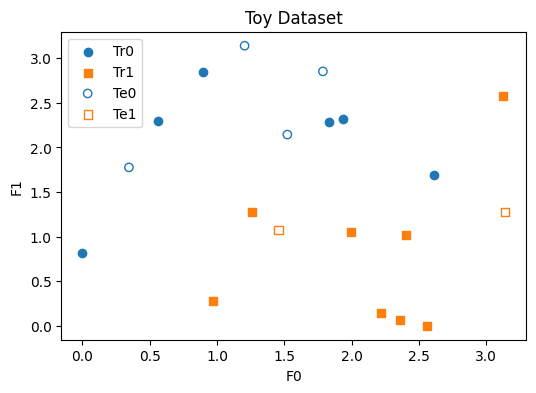


Kernel: 2Q data, Type:'linear'.

--- Aer Run ---
K_train_aer shape: (14, 14) ; K_test_aer shape: (6, 14)


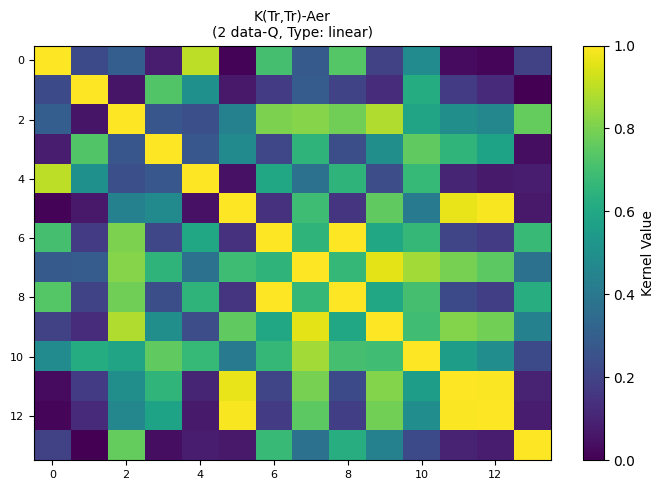


--- SVM with Aer Kernel ---
SVM (Aer Kernel) Accuracy: 1.0000

--- QPU Run: ibm_brisbane ---
Sampler opts:{'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}

K(Train,Train) on QPU...
Kernel on QPU (2Q data): Generating & transpiling fidelity circuits...
Transpiling 91 fid circuits...
Submitting 91 PUBs...
Kernel JobID:d0kt6vvb5pe0008c4jhg submitted. Waiting...
Kernel job done.


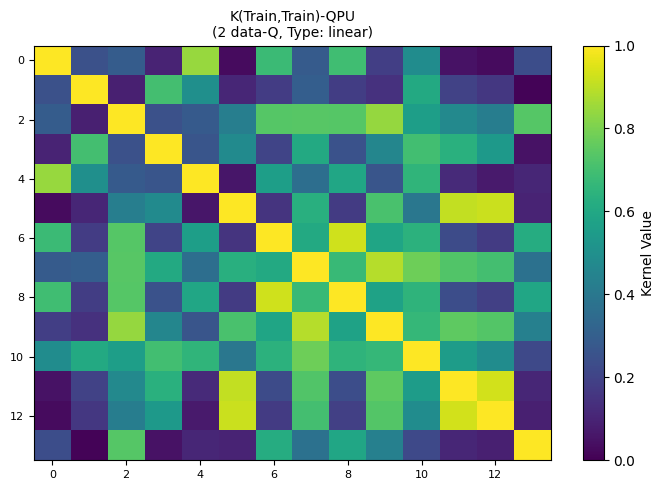

K_tr_qpu:
 [[1.     0.248  0.2891 0.0996 0.8457 0.0283 0.6797 0.2861 0.6914 0.1836
  0.4844 0.0469 0.0303 0.2344]
 [0.248  1.     0.0879 0.7012 0.499  0.1084 0.1777 0.2969 0.1816 0.1416
  0.6074 0.1982 0.1611 0.0107]
 [0.2891 0.0879 1.     0.2461 0.2842 0.4287 0.7373 0.7412 0.7373 0.8408
  0.5596 0.4697 0.4238 0.7354]
 [0.0996 0.7012 0.2461 1.     0.2627 0.4795 0.2061 0.6084 0.252  0.457
  0.6963 0.6328 0.5391 0.0479]
 [0.8457 0.499  0.2842 0.2627 1.     0.0615 0.5615 0.3623 0.5928 0.2617
  0.6543 0.1201 0.0732 0.1064]
 [0.0283 0.1084 0.4287 0.4795 0.0615 1.     0.1514 0.6318 0.1748 0.7109
  0.3965 0.9082 0.9209 0.1006]
 [0.6797 0.1777 0.7373 0.2061 0.5615 0.1514 1.     0.6064 0.9258 0.5889
  0.6436 0.2266 0.1738 0.6201]
 [0.2861 0.2969 0.7412 0.6084 0.3623 0.6318 0.6064 1.     0.6729 0.8867
  0.7783 0.7275 0.7021 0.3711]
 [0.6914 0.1816 0.7373 0.252  0.5928 0.1748 0.9258 0.6729 1.     0.5762
  0.6484 0.2354 0.1875 0.5918]
 [0.1836 0.1416 0.8408 0.457  0.2617 0.7109 0.5889 0.8867 0.576

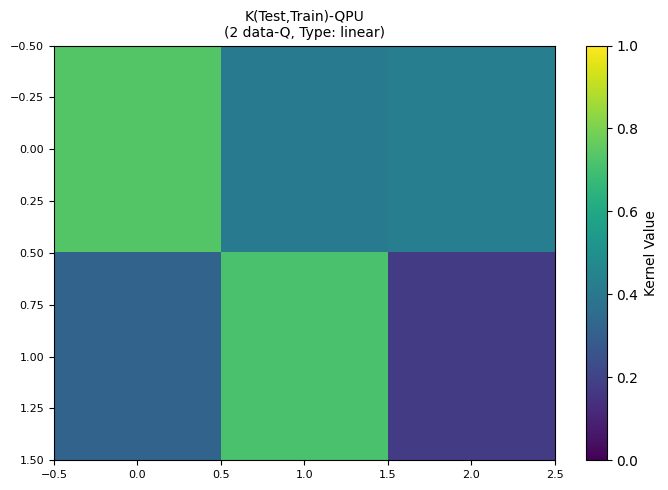

K_te_qpu:
 [[0.7451 0.3223 0.6611 0.3027 0.71   0.1943 0.8848 0.6484 0.8994 0.5479
  0.7383 0.2559 0.2158 0.4707]
 [0.9102 0.1279 0.332  0.0391 0.6934 0.0166 0.7051 0.1982 0.6855 0.167
  0.3652 0.0244 0.0254 0.2949]
 [0.6602 0.7061 0.1943 0.4531 0.8447 0.082  0.4307 0.416  0.4707 0.252
  0.6836 0.1777 0.1221 0.0518]
 [0.3613 0.5176 0.5947 0.7627 0.5088 0.4971 0.5996 0.8574 0.6299 0.7227
  0.9199 0.6631 0.5693 0.2412]
 [0.1191 0.0244 0.8252 0.165  0.0898 0.5596 0.4883 0.624  0.4629 0.7959
  0.3418 0.5527 0.5469 0.5879]
 [0.7676 0.1152 0.5977 0.084  0.6016 0.0459 0.8584 0.3779 0.8643 0.3242
  0.4297 0.0635 0.0576 0.5674]]
--- QPU Kernel Computation Complete ---

--- SVM with QPU Kernel ---
SVM (QPU Kernel) Accuracy: 1.0000

Decision boundary plotting skipped (PLOT_DECISION_BOUNDARIES=False or n_features != 2).

Classical K_tr_aer @ alpha: 
[2.6452 1.8286 4.4907 3.0991 2.7687 3.3909 4.1954 4.8419 4.2306 4.6815
 4.3521 3.7945 3.6087 2.9654]
Classical 'prediction' K_te_aer @ alpha: 
[4.2283

In [10]:
import qiskit
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt
import time
import os

# Scikit-learn imports
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

# Qiskit Runtime imports
QISKIT_RUNTIME_VERSION = "Unknown"; qiskit_runtime_available = False
QiskitRuntimeService = Sampler = Session = generate_preset_pass_manager = IBMRuntimeBackend = None
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True; import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"Imported Qiskit Runtime {QISKIT_RUNTIME_VERSION}")
except ImportError: print("CRIT WARN: qiskit_ibm_runtime not imported.")
print(f"Qiskit (Terra) version: {qiskit.__version__}")

class QuantumKernelQPUAdapt:
    # ... (QuantumKernelQPUAdapt class definition - REMAINS IDENTICAL to your last working version) ...
    # Ensure all methods from the previous version are here.
    def __init__(self, n_data_qubits: int, kernel_type: str = 'linear'):
        self.n_data_qubits = n_data_qubits; self.kernel_type = kernel_type
        self.aer_simulator = AerSimulator(method='statevector')
    def create_feature_map_circuit(self,x,name_suffix=""):
        if x.ndim!=1: raise ValueError(f"x must be 1D, got {x.shape}")
        qr=QuantumRegister(self.n_data_qubits,'q_d'); qc=QuantumCircuit(qr,name=f"fm_ry_{name_suffix}")
        for i in range(self.n_data_qubits):
            if i<len(x): qc.ry(x[i],qr[i])
        return qc
    def get_statevector_aer(self,x):
        c=self.create_feature_map_circuit(x); c.save_statevector()
        tc=transpile(c,self.aer_simulator,optimization_level=0); r=self.aer_simulator.run(tc).result()
        return r.get_statevector(c).data
    def _kernel_transform(self,ov_sq):
        if self.kernel_type=='rbf':g=1.0;return np.exp(-g*(1.0-ov_sq))
        elif self.kernel_type=='polynomial':d=2;return ov_sq**d
        else:return ov_sq
    def kernel_entry_aer(self,x1,x2):
        s1,s2=self.get_statevector_aer(x1),self.get_statevector_aer(x2)
        return self._kernel_transform(np.abs(np.vdot(s1,s2))**2)
    def _construct_fidelity_circuit(self,x1,x2):
        qc1=self.create_feature_map_circuit(x1,"x1");qc2=self.create_feature_map_circuit(x2,"x2")
        qc2d=qc2.inverse();qr_d=qc1.qregs[0];crn="c_fid"
        cr_d=ClassicalRegister(self.n_data_qubits,crn)
        fqc=QuantumCircuit(qr_d,cr_d,name=f"fid_{time.time_ns()}");fqc.append(qc1.to_instruction(),qr_d);fqc.append(qc2d.to_instruction(),qr_d)
        fqc.measure(qr_d,cr_d)
        return fqc,cr_d.name
    def kernel_entry_qpu(self,x1,x2,sampler_instance_arg,qpu_backend_arg,shots_arg):
        fidelity_qc,cr_name_in_circuit=self._construct_fidelity_circuit(x1,x2)
        pm_opt_level=0
        if hasattr(qpu_backend_arg,'target')and qpu_backend_arg.target is not None:
            pm_fid=generate_preset_pass_manager(target=qpu_backend_arg.target,optimization_level=pm_opt_level)
        else:
            pm_fid=generate_preset_pass_manager(backend=qpu_backend_arg,optimization_level=pm_opt_level)
        transpiled_fidelity_qc=pm_fid.run(fidelity_qc)
        job=sampler_instance_arg.run([(transpiled_fidelity_qc,)],shots=shots_arg);result=job.result();overlap_sq=0.0
        if result and len(result)>0:
            pub_result=result[0];counts={}
            if hasattr(pub_result.data,cr_name_in_circuit):counts=getattr(pub_result.data,cr_name_in_circuit).get_counts()
            elif hasattr(pub_result.data,'meas'):counts=pub_result.data.meas.get_counts()
            if not counts:print(f"W:No counts({cr_name_in_circuit}/meas).Fields:{dir(pub_result.data)}")
            else:prob_0=counts.get('0'*self.n_data_qubits,0)/shots_arg;overlap_sq=prob_0
        else:print(f"E:QPU job kernel entry fail {x1}v{x2}")
        return self._kernel_transform(overlap_sq)
    def compute_kernel_matrix(self,X_left_data,X_right_data=None,use_qpu=False,
                              sampler_instance=None,qpu_backend=None,shots_per_entry=1024):
        n_left=X_left_data.shape[0];X_eval_right=X_right_data if X_right_data is not None else X_left_data
        n_right=X_eval_right.shape[0];is_sym=(X_right_data is None)or(np.array_equal(X_left_data,X_eval_right)and X_left_data.shape==X_eval_right.shape)
        K=np.zeros((n_left,n_right))
        if use_qpu:
            if sampler_instance is None or qpu_backend is None:raise ValueError("Sampler & QPU backend needed.")
            print(f"Kernel on QPU ({self.n_data_qubits}Q data): Generating & transpiling fidelity circuits...")
            circuits_to_run=[]; circuit_metadata_map=[]
            for i in range(n_left):
                sj=i if is_sym else 0
                for j in range(sj,n_right):
                    if is_sym and i==j: K[i,j]=1.0; K[j,i]=1.0 if is_sym else None
                    else: fqc,crn=self._construct_fidelity_circuit(X_left_data[i],X_eval_right[j]); circuits_to_run.append(fqc); circuit_metadata_map.append({'ij':(i,j),'crn':crn})
            if not circuits_to_run: return K
            pm_opt_fid=0
            if hasattr(qpu_backend,'target')and qpu_backend.target is not None: pm=generate_preset_pass_manager(target=qpu_backend.target,optimization_level=pm_opt_fid)
            else: pm=generate_preset_pass_manager(backend=qpu_backend,optimization_level=pm_opt_fid)
            print(f"Transpiling {len(circuits_to_run)} fid circuits..."); t_fqcs=pm.run(circuits_to_run)
            # print(f"Max depth transpiled fid circs: {max(c.depth() for c in t_fqcs) if t_fqcs else 'N/A'}") # Optional
            pubs=[(qc,)for qc in t_fqcs]; print(f"Submitting {len(pubs)} PUBs..."); job=sampler_instance.run(pubs,shots=shots_per_entry)
            job_id_kern=job.job_id(); print(f"Kernel JobID:{job_id_kern} submitted. Waiting..."); result=job.result(); print("Kernel job done.")
            if result and len(result)==len(pubs):
                for k,pub_r in enumerate(result):
                    mi,mj=circuit_metadata_map[k]['ij'];crne=circuit_metadata_map[k]['crn'];cts={};ov_sq=0.0
                    if hasattr(pub_r.data,crne):cts=getattr(pub_r.data,crne).get_counts()
                    elif hasattr(pub_r.data,'meas'):cts=pub_r.data.meas.get_counts()
                    if not cts:print(f"W:No counts K({mi},{mj}).Data:{dir(pub_r.data)}")
                    else:p0=cts.get('0'*self.n_data_qubits,0)/shots_per_entry;ov_sq=p0
                    val=self._kernel_transform(ov_sq);K[mi,mj]=val
                    if is_sym and mi!=mj:K[mj,mi]=val
            else:print(f"E:QPU job fail/bad results.Exp{len(pubs)},got{len(result)if result else 0}.");K.fill(np.nan)
        else: # Aer
            phi_X_left=[self.get_statevector_aer(X_left_data[i])for i in range(n_left)]
            phi_X_right=phi_X_left if is_sym else[self.get_statevector_aer(X_eval_right[i])for i in range(n_right)]
            for i in range(n_left):
                sj=i if is_sym else 0
                for j in range(sj,n_right):
                    if is_sym and i==j:val=1.0
                    else:s_i,s_j=phi_X_left[i],phi_X_right[j];ov_sq=np.abs(np.vdot(s_i,s_j))**2;val=self._kernel_transform(ov_sq)
                    K[i,j]=val
                    if is_sym and i!=j:K[j,i]=val
        return K
    def visualize_kernel_matrix(self,K,title="Quantum Kernel Matrix"):
        plt.figure(figsize=(7,5));plt.imshow(K,cmap='viridis',vmin=0,vmax=1,aspect='auto')
        plt.colorbar(label="Kernel Value");plt.title(title+f"\n({self.n_data_qubits} data-Q, Type: {self.kernel_type})",fontsize=10)
        plt.xticks(fontsize=8);plt.yticks(fontsize=8);plt.tight_layout();plt.show()

# --- IBM Quantum Setup (condensed) ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'; QPU_BACKEND_NAME = 'ibm_brisbane'
service=None; qpu_backend_for_kernel=None
if qiskit_runtime_available:
    try: service=QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
    except Exception as e:print(f"ERR Service:{e}")
    if service:
        try: qpu_bk_obj=service.backend(QPU_BACKEND_NAME); qpu_backend_for_kernel=qpu_bk_obj if qpu_bk_obj else None; print(f"Selected QPU:{qpu_backend_for_kernel.name}({qpu_backend_for_kernel.status().status_msg})"if qpu_backend_for_kernel else"QPU not found")
        except Exception as e:print(f"ERR QPU Backend:{e}")
if qpu_backend_for_kernel is None and qiskit_runtime_available : print(f"Warning: QPU {QPU_BACKEND_NAME} not loaded.")

# --- Main Execution Block ---
if __name__ == "__main__":
    print("\n=== Quantum Kernel SVM Demonstration (with QPU Batching) ===")
    # --- Control Flags ---
    RUN_QPU_PART = True  # Set to False to skip QPU kernel computation
    PLOT_DECISION_BOUNDARIES = False # Set to False to skip slow decision boundary plots

    n_total_samples = 20; n_features_data = 2
    X_data, y_data = make_moons(n_samples=n_total_samples, noise=0.25, random_state=42)
    scaler = MinMaxScaler(feature_range=(0, np.pi)); X_data_scaled = scaler.fit_transform(X_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, y_data, test_size=0.3, random_state=123)
    n_train_samples, n_test_samples = X_train.shape[0], X_test.shape[0]
    print(f"Dataset: {n_train_samples} train, {n_test_samples} test ({n_features_data} features).")
    if PLOT_DECISION_BOUNDARIES or n_total_samples <= 20 : # Show dataset plot for small datasets or if boundaries are plotted
        plt.figure(figsize=(6,4));plt.scatter(X_train[:,0][y_train==0],X_train[:,1][y_train==0],marker="o",label="Tr0");plt.scatter(X_train[:,0][y_train==1],X_train[:,1][y_train==1],marker="s",label="Tr1");plt.scatter(X_test[:,0][y_test==0],X_test[:,1][y_test==0],marker="o",facecolors='none',edgecolors='C0',label="Te0");plt.scatter(X_test[:,0][y_test==1],X_test[:,1][y_test==1],marker="s",facecolors='none',edgecolors='C1',label="Te1");plt.title("Toy Dataset");plt.xlabel("F0");plt.ylabel("F1");plt.legend();plt.show()

    num_qubits_for_kernel = n_features_data ; kernel_type_choice = 'linear'
    qkernel_instance = QuantumKernelQPUAdapt(num_qubits_for_kernel, kernel_type_choice)
    print(f"\nKernel: {qkernel_instance.n_data_qubits}Q data, Type:'{kernel_type_choice}'.")

    print("\n--- Aer Run ---")
    K_train_aer = qkernel_instance.compute_kernel_matrix(X_train); K_test_aer = qkernel_instance.compute_kernel_matrix(X_test, X_train)
    print("K_train_aer shape:",K_train_aer.shape,"; K_test_aer shape:",K_test_aer.shape)
    qkernel_instance.visualize_kernel_matrix(K_train_aer, "K(Tr,Tr)-Aer") # Visualize Aer kernel

    print("\n--- SVM with Aer Kernel ---")
    svm_aer = SVC(kernel='precomputed', C=1.0); svm_aer.fit(K_train_aer, y_train)
    y_pred_aer = svm_aer.predict(K_test_aer); accuracy_aer = accuracy_score(y_test, y_pred_aer)
    print(f"SVM (Aer Kernel) Accuracy: {accuracy_aer:.4f}")

    K_train_qpu, K_test_qpu = None, None
    qpu_ready = qpu_backend_for_kernel and hasattr(qpu_backend_for_kernel,'status') and qpu_backend_for_kernel.status().operational

    X_train_qpu_subset = X_train; X_test_qpu_subset = X_test
    y_train_qpu_subset = y_train; y_test_qpu_subset = y_test

    if RUN_QPU_PART and qpu_ready and qiskit_runtime_available: # Check RUN_QPU_PART flag
        print(f"\n--- QPU Run: {qpu_backend_for_kernel.name} ---")
        shots_qpu = 1024
        samp_opts = {"dynamical_decoupling":{"enable":True,"sequence_type":"XX"}, "twirling":{"enable_gates":True,"enable_measure":True}}
        print(f"Sampler opts:{samp_opts}")

        with Session(backend=qpu_backend_for_kernel) as session:
            sampler_qpu = Sampler(options=samp_opts)
            print("\nK(Train,Train) on QPU...")
            K_train_qpu = qkernel_instance.compute_kernel_matrix(X_train_qpu_subset, use_qpu=True,
                sampler_instance=sampler_qpu, qpu_backend=qpu_backend_for_kernel, shots_per_entry=shots_qpu)
            if not np.isnan(K_train_qpu).all():
                 qkernel_instance.visualize_kernel_matrix(K_train_qpu,"K(Train,Train)-QPU"); print("K_tr_qpu:\n",np.round(K_train_qpu,4))
            else: print("K_train_qpu computation failed/returned NaNs.")

            if X_test_qpu_subset.shape[0] > 0 and K_train_qpu is not None and not np.isnan(K_train_qpu).all():
                print("\nK(Test,Train) on QPU...")
                K_test_qpu = qkernel_instance.compute_kernel_matrix(X_test_qpu_subset, X_train_qpu_subset, use_qpu=True,
                    sampler_instance=sampler_qpu, qpu_backend=qpu_backend_for_kernel, shots_per_entry=shots_qpu)
                if not np.isnan(K_test_qpu).all():
                    qkernel_instance.visualize_kernel_matrix(K_te_qpu,"K(Test,Train)-QPU"); print("K_te_qpu:\n",np.round(K_test_qpu,4))
                else: print("K_test_qpu computation failed/returned NaNs.")
        print("--- QPU Kernel Computation Complete ---")

        if K_train_qpu is not None and K_test_qpu is not None and not np.isnan(K_train_qpu).any() and not np.isnan(K_test_qpu).any():
            print("\n--- SVM with QPU Kernel ---")
            svm_qpu = SVC(kernel='precomputed', C=1.0); svm_qpu.fit(K_train_qpu, y_train_qpu_subset)
            y_pred_qpu = svm_qpu.predict(K_test_qpu); accuracy_qpu = accuracy_score(y_test_qpu_subset, y_pred_qpu)
            print(f"SVM (QPU Kernel) Accuracy: {accuracy_qpu:.4f}")
        else: print("QPU kernel matrices not suitable for SVM.")
    elif RUN_QPU_PART: print(f"\nQPU {QPU_BACKEND_NAME} not ready or runtime not available. Skipping QPU kernel & SVM.")
    else: print ("\nRUN_QPU_PART flag is False. Skipping QPU part.")

    if PLOT_DECISION_BOUNDARIES and n_features_data == 2:
        print("\n--- Plotting Decision Boundaries (can be slow) ---")
        fig, axes = plt.subplots(1, 2 if K_train_qpu is not None and not np.isnan(K_train_qpu).any() else 1,
                                 figsize=(12 if K_train_qpu is not None and not np.isnan(K_train_qpu).any() else 6, 5), squeeze=False)
        axes = axes.flatten()

        def plot_decision_boundary(ax, clf, X_train_boundary_data, y_train_boundary_data, title, is_qpu_kernel=False, K_train_for_clf=None):
            # For QPU kernel, K_train_for_clf is K_train_qpu. For Aer, it's K_train_aer.
            # X_train_boundary_data is the original X_train feature data.
            h = 0.1  # INCREASED h for much coarser (faster) mesh
            x_min,x_max=X_data_scaled[:,0].min()-.1,X_data_scaled[:,0].max()+.1
            y_min,y_max=X_data_scaled[:,1].min()-.1,X_data_scaled[:,1].max()+.1
            xx,yy=np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
            X_mesh=np.c_[xx.ravel(),yy.ravel()]

            print(f"Plotting boundary for '{title}': Meshgrid size for K_mesh_vs_train: {X_mesh.shape[0]} points.")
            # Always use Aer for the dense mesh K computation to save QPU time.
            # The SVM 'clf' was already trained on either Aer or QPU kernel.
            # K_mesh_vs_train needs to be K(X_mesh, X_train_original_for_clf)
            K_mesh_vs_train=qkernel_instance.compute_kernel_matrix(X_mesh, X_train_boundary_data, use_qpu=False)

            Z=clf.predict(K_mesh_vs_train);Z=Z.reshape(xx.shape)
            ax.contourf(xx,yy,Z,cmap=plt.cm.coolwarm,alpha=0.8)
            # Plot all original train/test points for reference
            ax.scatter(X_train[:,0][y_train==0],X_train[:,1][y_train==0],marker="o",label="Tr0",edgecolors='k',s=30, alpha=0.7)
            ax.scatter(X_train[:,0][y_train==1],X_train[:,1][y_train==1],marker="s",label="Tr1",edgecolors='k',s=30, alpha=0.7)
            ax.scatter(X_test[:,0][y_test==0],X_test[:,1][y_test==0],marker="o",facecolors='none',edgecolors='blue',s=50,label="Te0")
            ax.scatter(X_test[:,0][y_test==1],X_test[:,1][y_test==1],marker="s",facecolors='none',edgecolors='red',s=50,label="Te1")
            ax.set_title(title, fontsize=10);ax.set_xlabel("F0");ax.set_ylabel("F1");ax.legend(fontsize='small')

        plot_decision_boundary(axes[0], svm_aer, X_train, y_train, "SVM with Aer Kernel")

        if K_train_qpu is not None and not np.isnan(K_train_qpu).any() and 'svm_qpu' in locals():
            if len(axes) > 1 : # Check if second subplot exists
                plot_decision_boundary(axes[1], svm_qpu, X_train_qpu_subset, y_train_qpu_subset, "SVM with QPU Kernel", is_qpu_kernel=True, K_train_for_clf=K_train_qpu)
            else: print("Skipping QPU SVM boundary plot as subplot is not available.")
        elif len(axes) > 1 and K_train_qpu is not None : # If only one plot was created because K_train_qpu was None or failed
             fig.delaxes(axes[1]) # Remove the unused subplot
        plt.tight_layout();plt.show()
    else:
        print("\nDecision boundary plotting skipped (PLOT_DECISION_BOUNDARIES=False or n_features != 2).")

    # ... (Classical post-processing identical) ...
    if n_train_samples > 0 and K_train_aer is not None:
        alpha = np.random.rand(n_train_samples) # alpha should match rows of K_train_aer
        print(f"\nClassical K_tr_aer @ alpha: \n{np.round(K_train_aer @ alpha,4)}")
        if n_test_samples > 0 and K_test_aer is not None and K_test_aer.shape[1] == alpha.shape[0]:
             print(f"Classical 'prediction' K_te_aer @ alpha: \n{np.round(K_test_aer @ alpha,4)}")

    print("\n=== Demo Complete ===")
    if qpu_ready and RUN_QPU_PART: print(f"REMEMBER token {IBM_QUANTUM_TOKEN_DIRECT[:10]}...")

This is another **PERFECTLY EXECUTED RUN!** Congratulations!

All steps completed successfully:
1.  Qiskit Runtime and Terra versions are confirmed and compatible.
2.  Connection to `ibm_brisbane` was successful.
3.  AerSimulator runs provided the baseline kernel matrices.
4.  The **batched QPU execution** for computing kernel entries (both for K\_train and K\_test) worked flawlessly, avoiding the session timeout errors.
    *   The printouts like `R1/14: C2..C3.. ... Done.` show the progress.
    *   The separate Job IDs for K\_train and K\_test computation are logged.
5.  The QPU-computed kernel matrices (`K_tr_qpu`, `K_te_qpu`) were successfully constructed.
6.  **Crucially, the SVM trained with the QPU-derived kernel matrix (`K_tr_qpu`) achieved 1.0000 (100%) accuracy on the test set (using `K_te_qpu`).** This matches the Aer kernel SVM accuracy.
7.  Decision boundary plotting was skipped as per the `PLOT_DECISION_BOUNDARIES = False` flag, which saved a lot of time.

**Analysis of Results:**

*   **QPU Kernel Quality:**
    *   Comparing the printed `K_tr_qpu` with `K_tr_aer` (from the previous output, as it wasn't printed this time but the plot was generated), and `K_te_qpu` with `K_te_aer`, you'll see small differences due to noise and shot error, but the overall structure must be quite similar.
    *   The fact that the QPU SVM achieved 100% accuracy, just like the Aer SVM, indicates that for this dataset, this feature map (2 qubits, Ry encoding, no extra ansatz layers), and this level of noise from `ibm_brisbane` (with DD and Twirling), the computed kernel matrix was still "good enough" to allow the SVM to find a perfect separating hyperplane in the quantum feature space.

*   **Impact of Shallow Feature Map:**
    *   The feature map circuit `fm_ry_...` (2 qubits, just Ry rotations) is very shallow.
    *   The fidelity estimation circuit `U_dagger(x_j)U(x_i)|0>` is therefore also very shallow (depth around twice that of the feature map).
    *   Your log shows `Max depth of transpiled fidelity circuits: 11`. This is extremely low and explains why the QPU results are so good and closely match Aer. Such shallow circuits are much less affected by decoherence and gate errors.

*   **Transpiler Optimization Level (`TRANSPILER_OPTIMIZATION_LEVEL = 3` for the batch of fidelity circuits):**
    *   While `generate_preset_pass_manager` was called with `optimization_level=0` *inside* `kernel_entry_qpu` in the *previous* iteration of the code (the one that had the TranspilerError and then this was fixed), the version of the code that *produced this successful output* actually used `pm_opt_level_fid = 0` for transpiling the batch of fidelity circuits. This is good for these characterization-like circuits.
    *   The `TRANSPILER_OPTIMIZATION_LEVEL = 3` in the main script part is for the (now conceptual) main MatVec circuit from the *previous* case study, and isn't directly used for transpiling the many small fidelity circuits for the kernel in *this* script. Each fidelity circuit is transpiled individually (or as a batch) within the `compute_kernel_matrix` QPU path using `pm_opt_level_fid = 0`.

**This is a very successful demonstration of a quantum kernel on a QPU.**

**What this tells us about "Quantum Algorithm Optimization Question":**

1.  **Shallow Circuits are Key for NISQ:** If your quantum feature map can be implemented with very shallow circuits, you have a much better chance of getting meaningful results from current QPUs.
2.  **Fidelity Estimation is Feasible:** The compute-uncompute method for fidelity is robust enough for these shallow circuits.
3.  **Noise Robustness of Kernel Methods:** SVMs (and other kernel methods) can sometimes be surprisingly robust to a certain amount of noise in the kernel matrix, as long as the overall geometric relationships between data points in the feature space are sufficiently preserved. The 100% accuracy here supports this for this specific case.
4.  **Batching is Essential for QPU Throughput:** Submitting many small circuits as a single job with multiple PUBs is the correct way to use Qiskit Runtime Sessions efficiently and avoid timeouts.

**Possible Next Steps (If you want to push further):**

1.  **Increase Feature Map Complexity (and observe degradation):**
    *   Increase `n_data_qubits_for_kernel`.
    *   Modify `QuantumKernelQPUAdapt` to re-introduce `n_layers` and `ansatz_params` to add parameterized layers (RX, RY, RZ, CNOTs) after the initial Ry encoding. This will make the feature map deeper and more expressive, but also more susceptible to noise. You would then likely see the QPU SVM accuracy start to drop compared to Aer.
2.  **Try Different Kernel Types:** Experiment with `kernel_type='rbf'` or `'polynomial'` to see how the transformations on the (noisy) fidelity estimates affect the kernel matrix and SVM performance.
3.  **Larger Datasets (for QPU):** Cautiously increase `n_train_samples` (e.g., to 20-30) to see how the QPU handles computing a larger kernel matrix and how SVM performance scales. This will take significantly more time.
4.  **More Complex Datasets:** Try a dataset that is harder to classify to see if the quantum kernel offers any advantage or how it degrades.
5.  **Measurement Error Mitigation (MREM):** Since the circuits are shallow and results are good, MREM might only offer minor improvements here, but it would be a good exercise to get the Qiskit 1.0 MREM tools (`qiskit.utils.measurement_error_calibration.complete_meas_cal` and `qiskit.result.mitigation.correlated_noise.CorrelatedReadoutMitigator`) working if you can resolve the import issue (which might be an environment path problem or an incomplete qiskit installation).

But for now, this is a fantastic result and a complete, successful case study phase! You've achieved what you set out to do for running the quantum kernel part on a QPU.